Neural Network

In [2]:
from sklearn.metrics import (matthews_corrcoef, confusion_matrix,
                             classification_report, ConfusionMatrixDisplay)
from joblib import dump
from ucimlrepo import fetch_ucirepo
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential, regularizers, callbacks
from tensorflow.keras.layers import InputLayer, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

covertype = fetch_ucirepo(id=31)

X = covertype.data.features
y = covertype.data.targets

Clean, Balance, and Split Data

In [3]:
# preprocess data using utils.py
X_clean, y_clean = utils.clean_data(X, y)

X_train, X_test, y_train, y_test = utils.split_data(X_clean, y_clean)

# create a validation set
validation_ratio = 0.1

X_train, X_val, y_train, y_val = utils.split_data(X_train, y_train, validation_ratio)

Create Model

In [4]:
# This model will follow the class implementation
model = Sequential([
    InputLayer(input_shape=(54,1)),
    Flatten(),      # ensure our data is flat
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    # Dense(256, activation='relu'),
    # Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(8, activation='softmax')  # 7 categories
])

C:\Users\Aidan\Documents\pythonschool\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Compile our new model

In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [6]:
# Summary of Data
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,008 (187.53 KB)

 Trainable params: 48,008 (187.53 KB)

 Non-trainable params: 0 (0.00 B)

Training of Model

In [7]:
fitted = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=256,
    verbose=1
   # ,callbacks=[early_stopping]
)

Epoch 1/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5191 - loss: 6.8542 - val_accuracy: 0.6033 - val_loss: 3.5240
Epoch 2/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5970 - loss: 2.4693 - val_accuracy: 0.6350 - val_loss: 1.5725
Epoch 3/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6230 - loss: 1.7126 - val_accuracy: 0.6333 - val_loss: 1.4397
Epoch 4/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6476 - loss: 1.2337 - val_accuracy: 0.6932 - val_loss: 0.9983
Epoch 5/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6641 - loss: 1.0269 - val_accuracy: 0.6312 - val_loss: 1.1292
Epoch 6/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6814 - loss: 0.8763 - val_accuracy: 0.6634 - val_loss: 0.8801
Epoch 7/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6961 - loss: 0.7998 - val_accuracy: 0.6796 - val_loss: 0.9100
Epoch 8/15
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7059 - loss: 0.7461 - 

 ## Visualizations

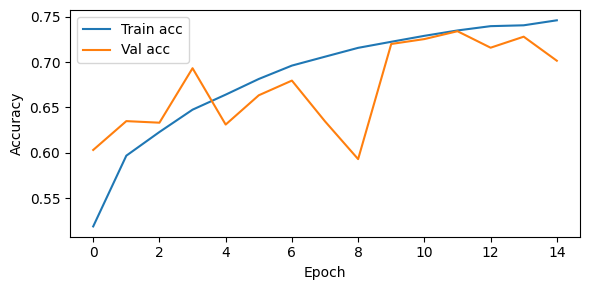

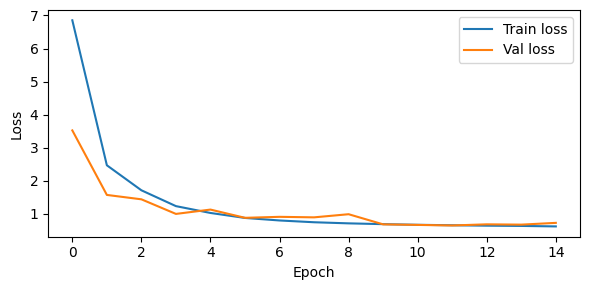

In [8]:
plt.figure(figsize=(6,3))
plt.plot(fitted.history["accuracy"], label="Train acc")
plt.plot(fitted.history["val_accuracy"], label="Val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(fitted.history["loss"], label="Train loss")
plt.plot(fitted.history["val_loss"], label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout()
plt.show()

## Results

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Test MCC: 0.5239906285934698

Confusion Matrix:
[[22220 20021    41     0     4    24    58]
 [ 3697 50312  1883     0    49   702    18]
 [    0   343  6274    51     0   483     0]
 [    0     0   185   323     0    41     0]
 [    6  1635   106     0   110    42     0]
 [    0   418  1598    23     0  1434     0]
 [ 2605   208     0     0     3     0  1286]]

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.52      0.63     42368
           2       0.69      0.89      0.78     56661
           3       0.62      0.88      0.73      7151
           4       0.81      0.59      0.68       549
           5       0.66      0.06      0.11      1899
           6       0.53      0.41      0.46      3473
           7       0.94      0.31      0.47      4102

    accuracy                           0.71    116203
   macro avg       0.72      0.52      0.55    116203
weighted avg       0.72    

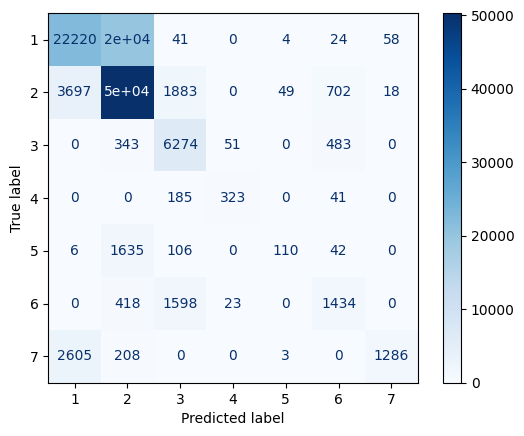

In [12]:
# See how our model does on the test set

# TODO: deal with softmax to a prediction and fix model rigidness.
# todo: categorize using sklearn on the y_true
y_predicted = model.predict(X_test)

# take argmax of y_predicted to find what it predicted
y_pred_idx = [np.argmax(row) for row in y_predicted]

test_mcc = matthews_corrcoef(y_test, y_pred_idx)
print("Test MCC:", test_mcc)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_idx))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_idx))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_idx, cmap="Blues")
plt.show()

In [14]:
# dump model
dump(model, "../data/best_neural_network.joblib")

['../data/best_neural_network.joblib']